In [648]:
import numpy as np
from numpy import ma
import xarray as xr
from glob import glob
from datetime import datetime, timedelta
from scipy import ndimage as ndi
from scipy import interpolate
from dateutil.parser import parse as parse_date
import argparse
from python_toolbox import abi_tools, dataset_tools, opt_flow
import matplotlib.pyplot as plt
import cv2 as cv
plt.rcParams.update({'figure.max_open_warning': 0})

In [697]:
# Getting files (on jasmin)

base_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/RadC/'

start_date = datetime(2018,6,19,16)
end_date = datetime(2018,6,20,4)
doy_start = (start_date - datetime(start_date.year, 1, 1)).days + 1
doy_end = (end_date - datetime(end_date.year, 1, 1)).days + 1

file_names = []
for year in range(start_date.year, end_date.year+1):
    year_str = str(year).zfill(4)
    if start_date.year == end_date.year:
        for doy in range(doy_start, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == start_date.year:
        for doy in range(doy_start, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    elif year == end_date.year:
        for doy in range(1, doy_end+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))
    else:
        for doy in range(1, (datetime(year+1,1,1)-datetime(year,1,1)).days+1):
            doy_str = str(doy).zfill(3)
            goes_path = base_path +year_str+'/'+doy_str+'/'
            file_names.extend(glob(goes_path+'*/*C08_*.nc'))

# Get all filenames
goes_files = [abi_tools.get_goes_abi_files(f) for f in file_names]
# Filter for start and end date
goes_files = [f for f in goes_files if f[0] >= start_date and f[0] <= end_date and len(f) == 17]

len(goes_files)

143

In [698]:
# Get brightness temperature for channel 8,10,13 and 15
# Upper level water vapour (6.2um)
C8_data = abi_tools.get_abi_ds_from_files([f[8] for f in goes_files])[:,600:900,1300:1600]
# Lower level water vapour (7.3um)
C10_data = abi_tools.get_abi_ds_from_files([f[10] for f in goes_files])[:,600:900,1300:1600]
# Clean IR LW window channel(10.8um)
C13_data = abi_tools.get_abi_ds_from_files([f[13] for f in goes_files])[:,600:900,1300:1600]
# Dirty IR LW window channel(12.0um)
C15_data = abi_tools.get_abi_ds_from_files([f[15] for f in goes_files])[:,600:900,1300:1600]

dataset_tools.match_coords([C13_data,C10_data,C8_data,C15_data])


In [699]:
C13_data = C13_data.compute()

In [700]:
# water vapour and split window differences
wvd = (C8_data - C10_data).compute()
swd = (C13_data - C15_data).compute()


Text(0.5,1,'Combined difference')

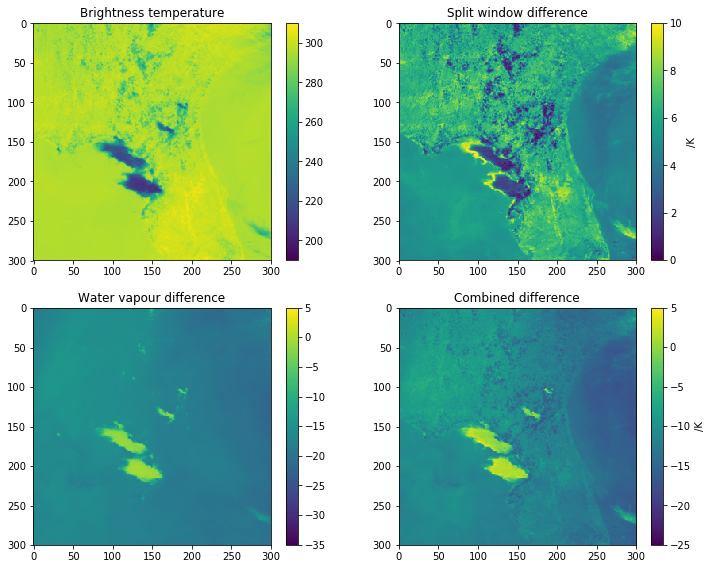

In [701]:
fig, ax = plt.subplots(2,2,figsize=(12,9.6))
bt = ax[0,0].imshow(C13_data[24], vmin=190,vmax=310)
plt.colorbar(bt, ax=ax[0,0])
ax[0,0].set_title('Brightness temperature')

wv = ax[1,0].imshow(wvd[24], vmin=-35,vmax=5)
plt.colorbar(wv, ax=ax[1,0])
ax[1,0].set_title('Water vapour difference')

sw = ax[0,1].imshow(swd[24], vmin=0,vmax=10)
plt.colorbar(sw, label='/K', ax=ax[0,1])
ax[0,1].set_title('Split window difference')

sw = ax[1,1].imshow(swd[24]+wvd[24], vmin=-25,vmax=5)
plt.colorbar(sw, label='/K', ax=ax[1,1])
ax[1,1].set_title('Combined difference')


Note that the split window temperatures are low in the middle of deep clouds, but high at the edges. I am using this to distinguish between the core and anvil parts of DCCs

In [702]:
field_flow = opt_flow.get_flow_func(C13_data, replace_missing=True,
                                    pyr_scale=0.5, levels=6, winsize=31, 
                                    iterations=5, poly_n=7, poly_sigma=1.5, 
                                    flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)

Flow func can now be indexed and the individual vectors accessed separately:

In [703]:
field_flow[0,:10](1)[0].shape

(10, 300)

In [704]:
field_flow.flow_x_for[0]

masked_array(
  data=[[4.282625377527438e-05, 6.48265122435987e-05,
         8.935392543207854e-05, ..., -0.00032858221675269306,
         -0.00024306403065565974, -0.00016943119408097118],
        [7.723682938376442e-05, 0.00011802242806879804,
         0.00016472648712806404, ..., -0.0005949213518761098,
         -0.0004319121944718063, -0.0002966407919302583],
        [0.00012827284808736295, 0.00019710251945070922,
         0.0002774142485577613, ..., -0.0009953639237210155,
         -0.0007119686342775822, -0.00048309663543477654],
        ...,
        [-1.8371520127402619e-07, -3.965839141528704e-07,
         -7.827975423424505e-07, ..., -0.07697701454162598,
         -0.04967670515179634, -0.030172931030392647],
        [-1.0713440445897504e-07, -2.3483256939016428e-07,
         -4.6893646299395186e-07, ..., -0.034096069633960724,
         -0.022224167361855507, -0.013653910718858242],
        [-5.8510039480097475e-08, -1.3057029946139664e-07,
         -2.642277081577049e-07, ..

Text(0.5,1,'Y flow vector')

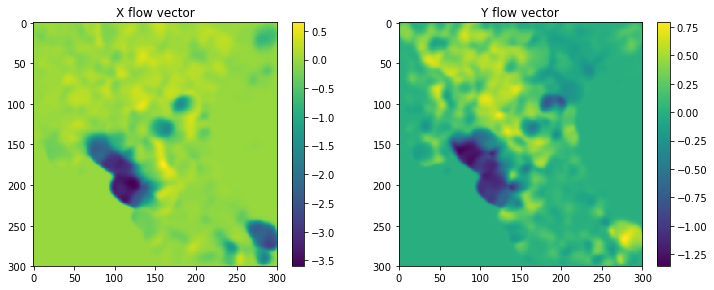

In [705]:
fig, ax = plt.subplots(1,2,figsize=(12,4.5))
x_vec = ax[0].imshow(field_flow(1)[0][24])
plt.colorbar(x_vec, ax=ax[0])
ax[0].set_title('X flow vector')

y_vec = ax[1].imshow(field_flow(1)[1][24])
plt.colorbar(y_vec, ax=ax[1])
ax[1].set_title('Y flow vector')



## Semi-lagrangian BT cooling

In [706]:
# this gets a 3*arr.shape array of the field interpolated by one frame forwards and backwards
bt_stack = opt_flow.get_flow_stack(C13_data, field_flow).data


In [707]:
dx, dy = abi_tools.get_abi_pixel_lengths(C13_data)

In [708]:
# delta t, and also the spatial second derivative to find peaks in the brightness temperature
bt_dt = np.gradient(bt_stack, axis=0)[1]
bt_grad = (np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=1), axis=1)/dy**2,
                (0,1.5,1.5)), 0), 1) 
           * np.minimum(np.maximum(ndi.gaussian_filter(
                np.gradient(np.gradient(bt_stack[1], axis=2), axis=2)/dx**2,
                (0,1.5,1.5)), 0), 1))**0.5

# gaussian filter applied to grad bt to reduce noise

Text(0.5,1,'grad BT')

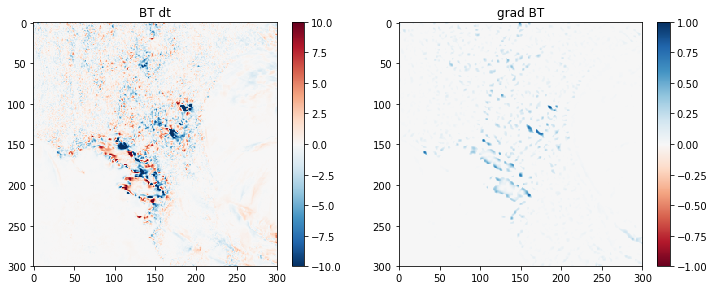

In [709]:
fig, ax = plt.subplots(1,2,figsize=(12,4.5))
btdt = ax[0].imshow(bt_dt[24],vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar(btdt, ax=ax[0])
ax[0].set_title('BT dt')

gradbt = ax[1].imshow(bt_grad[24],vmin=-1,vmax=1,cmap='RdBu')
plt.colorbar(gradbt, ax=ax[1])
ax[1].set_title('grad BT')


By multiplying these fields we can get a metric for how much a peak in the BT field (positive grad) is growing (negative BTdt)

In [822]:
bt_growth = np.minimum(np.maximum(np.maximum(-bt_dt,0) * bt_grad, 0),10)


In [908]:
#dilate the field in a semi-lagrangian way
bt_growth_dilate = opt_flow.flow_convolve_nearest(bt_growth, field_flow, 
                                           structure=ndi.generate_binary_structure(3,2),
                                           function=np.nanmax)


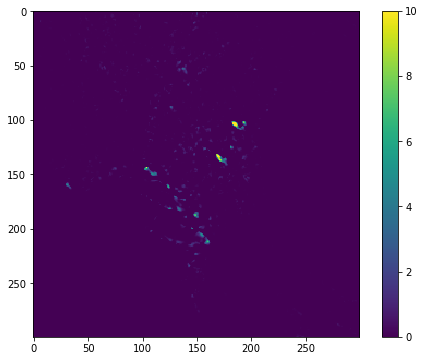

In [823]:
plt.figure(figsize=(8,6))
plt.imshow(bt_growth[24])
plt.colorbar()

Text(0.5,1,'BT growth metric')

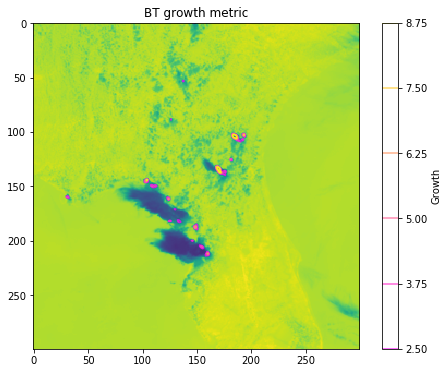

In [825]:
plt.figure(figsize=(8,6))
plt.imshow(C13_data[24],cmap='viridis',vmax=310,vmin=190)
plt.contour(bt_growth[24],np.arange(2.5,11.25,1.25), alpha=0.75, cmap='spring')
# plt.gca().invert_yaxis()
plt.colorbar(label='Growth')
plt.title('BT growth metric')

I've found that 2.5 is a good value for this, it's approximately equal to a peak cooling of 0.5K/minute

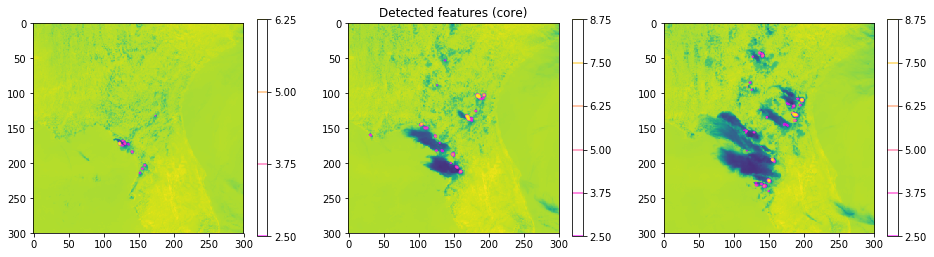

In [826]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],cmap='viridis',vmin=190,vmax=310)
c0 = ax[0].contour(bt_growth[12],np.arange(2.5,11.25,1.25), alpha=0.75, cmap='spring')
plt.colorbar(c0, ax=ax[0])

m1 = ax[1].imshow(C13_data[24],cmap='viridis',vmin=190,vmax=310)
c1 = ax[1].contour(bt_growth[24],np.arange(2.5,11.25,1.25), alpha=0.75, cmap='spring')
plt.colorbar(c1, ax=ax[1])
ax[1].set_title('Detected features (core)')

m2 = ax[2].imshow(C13_data[36],cmap='viridis',vmin=190,vmax=310)
c2 = ax[2].contour(bt_growth[36],np.arange(2.5,11.25,1.25), alpha=0.75, cmap='spring')
plt.colorbar(c2, ax=ax[2])


## Semi-lagrangian watershedding

In [827]:
upper_thresh = -5
lower_thresh = -15
markers = wvd>upper_thresh
markers = np.logical_and(markers, bt_growth>2.5).to_masked_array()
mask = (wvd<lower_thresh).to_masked_array()
for i in range(np.minimum(3, (mask.shape[0]-1)//2)):
    # Semi-lagrangian erosion of the mask by up to three steps
    mask = opt_flow.flow_convolve_nearest(mask, field_flow, 
                                          structure=ndi.generate_binary_structure(3,2),
                                          function=np.nanmin)

/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


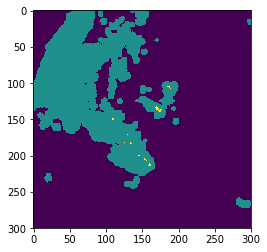

In [828]:
plt.imshow((markers.astype(int)-mask.astype(int))[24])

Markers in yellow. Mask in dark blue. Unfilled regions are in teal

In [717]:
# Sobel edge detection for watershedding. Combine WVD, SWD and growth to find regions
inner_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve( 
                                                  opt_flow.get_flow_stack((wvd-swd+bt_growth-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


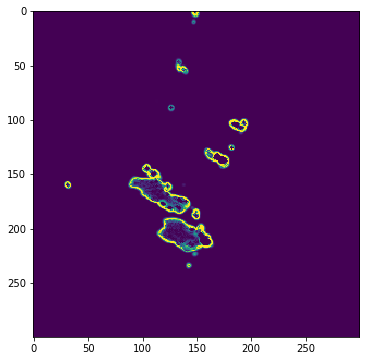

In [718]:
plt.figure(figsize=(8,6))
plt.imshow(inner_edges[24],vmin=0,vmax=50)

In [829]:
# Watershed
features = opt_flow.flow_network_watershed(inner_edges, markers, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 4363224
Convergence
Iteration: 1
Pixels converged 9446134
Convergence
Iteration: 2
Pixels converged 9908264
Convergence
Iteration: 3
Pixels converged 10362688
Convergence
Iteration: 4
Pixels converged 10909992
Convergence
Iteration: 5
Pixels converged 11553731
Convergence
Iteration: 6
Pixels converged 12285166
Convergence
Iteration: 7
Pixels converged 12841892
Convergence
Iteration: 8
Pixels converged 12870000
All pixels converged
Filling basins
Joining labels
Max label: 35397
max_markers: 1
Iteration: 1
Remaining labels: 6849
Iteration: 2
Remaining labels: 1380
Iteration: 3
Remaining labels: 293
Iteration: 4
Remaining labels: 58
Iteration: 5
Remaining labels: 16
Iteration: 6
Remaining labels: 7
Iteration: 7
Remaining labels: 2


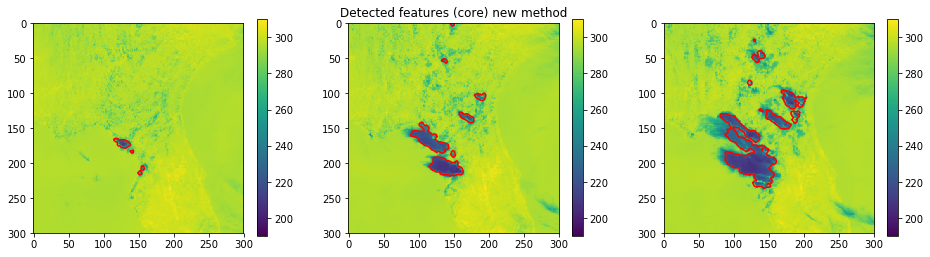

In [830]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (core) new method')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(features[36],[0.5],colors=['red'])


In [831]:
# New struct test
test_struct = ndi.generate_binary_structure(3,2)
test_struct[2] = 0
print(test_struct)
test_features = opt_flow.flow_network_watershed(inner_edges, markers, field_flow, mask=mask, 
                                           structure=test_struct, 
                                           debug_mode=True)


[[[False  True False]
  [ True  True  True]
  [False  True False]]

 [[ True  True  True]
  [ True  True  True]
  [ True  True  True]]

 [[False False False]
  [False False False]
  [False False False]]]
Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 4351905
Convergence
Iteration: 1
Pixels converged 9437938
Convergence
Iteration: 2
Pixels converged 9910045
Convergence
Iteration: 3
Pixels converged 10371039
Convergence
Iteration: 4
Pixels converged 10918993
Convergence
Iteration: 5
Pixels converged 11560960
Convergence
Iteration: 6
Pixels converged 12288727
Convergence
Iteration: 7
Pixels converged 12842155
Convergence
Iteration: 8
Pixels converged 12870000
All pixels converged
Filling basins
Joining labels
Max label: 45500
max_markers: 1
Iteration: 1
Remaining labels: 5163
Iteration: 2
Remaining labels: 631
Iteration: 3
Remaining labels: 87
Iteration: 4
Remaining labels: 14
Iteration: 5
Remaining labels: 5
Iteration: 6
Remaining labels: 3
Iteration

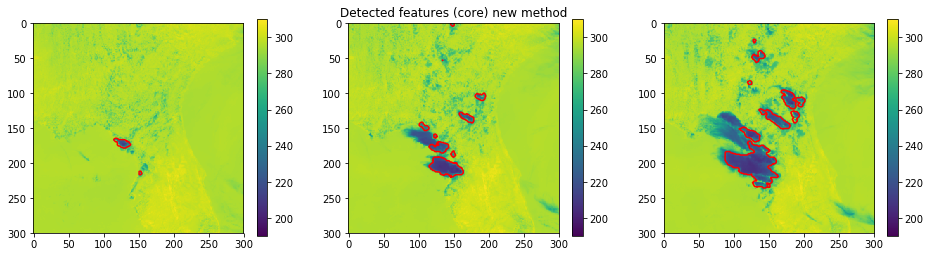

In [832]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(test_features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(test_features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (core) new method')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(test_features[36],[0.5],colors=['red'])


Repeat for outer regions

In [ ]:

outer_edges = opt_flow.flow_sobel(opt_flow.get_flow_stack(
                                      xr.DataArray(
                                          np.minimum(np.maximum(
                                              opt_flow.flow_convolve(
                                                  opt_flow.get_flow_stack((wvd+swd+bt_growth-5).compute(), 
                                                                          field_flow, method='linear').to_masked_array(), 
                                                  function=np.nanmax)
                                              , lower_thresh), upper_thresh), 
                                          dims=('t','y','x')),
                                      field_flow).compute().to_masked_array(), 
                                  direction='uphill', magnitude=True)


In [ ]:
plt.figure(figsize=(8,6))
plt.imshow(outer_edges[24],vmin=0,vmax=50)

In [723]:
# Watershed
outer = opt_flow.flow_network_watershed(outer_edges, features, field_flow, mask=mask, 
                                           structure=ndi.morphology.generate_binary_structure(3,2), 
                                           debug_mode=True)


Iteration: 1
Remaining labels: 17234
Iteration: 2
Remaining labels: 3928
Iteration: 3
Remaining labels: 873
Iteration: 4
Remaining labels: 173
Iteration: 5
Remaining labels: 26
Iteration: 6
Remaining labels: 2


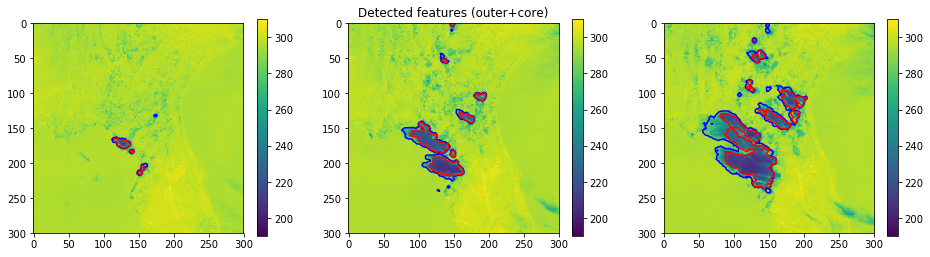

In [724]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(outer[12],[0.5],colors=['blue'])
ax[0].contour(features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(outer[24],[0.5],colors=['blue'])
ax[1].contour(features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(outer[36],[0.5],colors=['blue'])
ax[2].contour(features[36],[0.5],colors=['red'])


In [833]:
# Watershed
test_outer = opt_flow.flow_network_watershed(outer_edges, features, field_flow, mask=mask, 
                                           structure=test_struct, 
                                           debug_mode=True)


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 3536722
Convergence
Iteration: 1
Pixels converged 11479116
Convergence
Iteration: 2
Pixels converged 12186631
Convergence
Iteration: 3
Pixels converged 12437056
Convergence
Iteration: 4
Pixels converged 12620713
Convergence
Iteration: 5
Pixels converged 12770091
Convergence
Iteration: 6
Pixels converged 12858463
Convergence
Iteration: 7
Pixels converged 12870000
All pixels converged
Filling basins
Joining labels
Max label: 109888
max_markers: 1
Iteration: 1
Remaining labels: 11312
Iteration: 2
Remaining labels: 1194
Iteration: 3
Remaining labels: 120
Iteration: 4
Remaining labels: 13
Iteration: 5
Remaining labels: 2


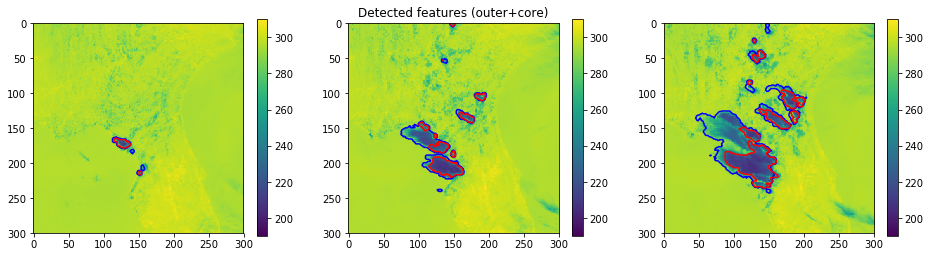

In [834]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
ax[0].contour(test_outer[12],[0.5],colors=['blue'])
ax[0].contour(test_features[12],[0.5],colors=['red'])

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
ax[1].contour(test_outer[24],[0.5],colors=['blue'])
ax[1].contour(test_features[24],[0.5],colors=['red'])
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
ax[2].contour(test_outer[36],[0.5],colors=['blue'])
ax[2].contour(test_features[36],[0.5],colors=['red'])


The 'outer' region seems to pick up the extent of the anvil outflow fairly well

Now lets try segmentation using the previous result as a mask

In [757]:
segmentation_markers = ndi.label(markers)[0]
field = C13_data-wvd+swd-bt_growth

segment_features = opt_flow.flow_network_watershed(field.data, segmentation_markers, field_flow, 
                                                   mask=np.logical_not(test_outer),
                                           structure=test_struct, 
                                           debug_mode=True)


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 2101990
Convergence
Iteration: 1
Pixels converged 11111902
Convergence
Iteration: 2
Pixels converged 11453782
Convergence
Iteration: 3
Pixels converged 11930778
Convergence
Iteration: 4
Pixels converged 12474139
Convergence
Iteration: 5
Pixels converged 12834872
Convergence
Iteration: 6
Pixels converged 12869970
Convergence
Iteration: 7
Pixels converged 12870000
All pixels converged
Filling basins
Joining labels
Max label: 12895
max_markers: 385
Iteration: 1
Remaining labels: 996
Iteration: 2
Remaining labels: 454
Iteration: 3
Remaining labels: 395
Iteration: 4
Remaining labels: 388
Iteration: 5
Remaining labels: 386


In [756]:
type(field)

xarray.core.dataarray.DataArray

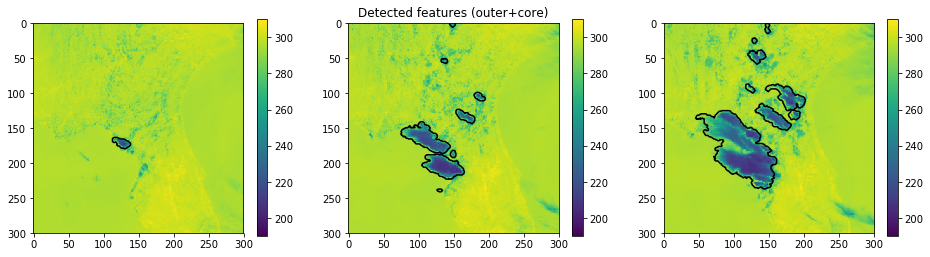

In [779]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
# ax[0].contour(test_outer[12],[0.5],colors=['blue'])
ax[0].contour(segment_features[12],[0.5], cmap='inferno')

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
# ax[1].contour(test_outer[24],[0.5],colors=['blue'])
ax[1].contour(segment_features[24],[0.5], cmap='inferno')
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
# ax[2].contour(test_outer[36],[0.5],colors=['blue'])
ax[2].contour(segment_features[36],[0.5], cmap='inferno')


In [985]:
# testing a new structure
new_struct = np.zeros([3,3,3], dtype='bool')
new_struct[:,1,1] = 1

In [993]:
new_struct

array([[[False, False, False],
        [False,  True, False],
        [False, False, False]],

       [[False, False, False],
        [False,  True, False],
        [False, False, False]],

       [[False, False, False],
        [False,  True, False],
        [False, False, False]]])

In [986]:
segment_markers = opt_flow.flow_network_watershed(-bt_growth_dilate, markers, field_flow, 
                                                   mask=np.logical_or(bt_growth_dilate<1., np.logical_not(test_outer)),
                                           structure=new_struct, 
                                           debug_mode=True)


/home/users/wkjones/miniconda2/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 59916
Convergence
Iteration: 1
Pixels converged 12856618
Convergence
Iteration: 2
Pixels converged 12867521
Convergence
Iteration: 3
Pixels converged 12869929
Convergence
Iteration: 4
Pixels converged 12870000
All pixels converged
Filling basins
Joining labels
Max label: 7069
max_markers: 1
Iteration: 1
Remaining labels: 509
Iteration: 2
Remaining labels: 21
Iteration: 3
Remaining labels: 2


In [990]:
segment_labels = ndi.label(segment_markers, structure=ndi.generate_binary_structure(3,2))[0]

In [977]:
segment_labels = ndi.label(opt_flow.flow_convolve_nearest(
                                np.logical_and(segment_markers, test_outer),
                                field_flow,
                                structure=ndi.generate_binary_structure(3,1),
                                function=np.nanmin),
                            structure=ndi.generate_binary_structure(3,1))[0]

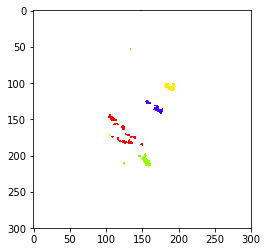

In [991]:
plt.imshow(ma.array(segment_labels[24],mask=segment_labels[24]<=0), cmap='prism')

In [992]:
segment_labels.max()

106

In [994]:
field = C13_data-wvd+swd-bt_growth


In [995]:
segment_features2 = opt_flow.flow_network_watershed(field.data, segment_labels, field_flow, 
                                                   mask=np.logical_not(test_outer),
                                           structure=ndi.generate_binary_structure(3,2), 
                                           debug_mode=True)


Calculating nearest neighbours
Finding network convergence locations
Pixels to fill: 2053973
Convergence
Iteration: 1
Pixels converged 11138849
Convergence
Iteration: 2
Pixels converged 11471982
Convergence
Iteration: 3
Pixels converged 11945484
Convergence
Iteration: 4
Pixels converged 12482206
Convergence
Iteration: 5
Pixels converged 12834708
Convergence
Iteration: 6
Pixels converged 12870000
All pixels converged
Filling basins
Joining labels
Max label: 8260
max_markers: 106
Iteration: 1
Remaining labels: 1122
Iteration: 2
Remaining labels: 281
Iteration: 3
Remaining labels: 153
Iteration: 4
Remaining labels: 128
Iteration: 5
Remaining labels: 108
Iteration: 6
Remaining labels: 107


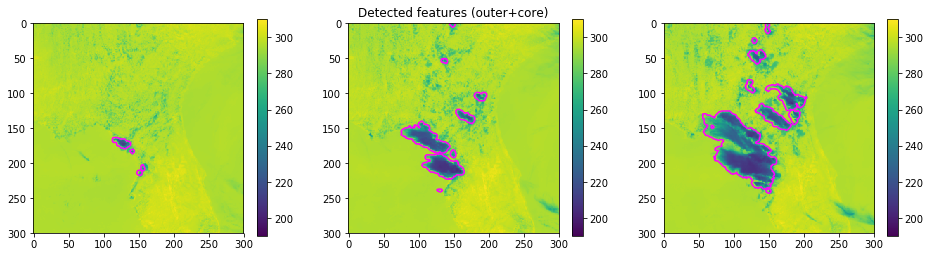

In [996]:
fig, ax = plt.subplots(1,3,figsize=(16,4))

m0 = ax[0].imshow(C13_data[12],vmin=190,vmax=310)
plt.colorbar(m0, ax=ax[0])
# ax[0].contour(test_outer[12],[0.5],colors=['blue'])
ax[0].contour(segment_features2[12],np.arange(segment_markers.max())+0.5,cmap='spring')

m1 = ax[1].imshow(C13_data[24],vmin=190,vmax=310)
plt.colorbar(m1, ax=ax[1])
# ax[1].contour(test_outer[24],[0.5],colors=['blue'])
ax[1].contour(segment_features2[24],np.arange(segment_markers.max())+0.5,cmap='spring')
ax[1].set_title('Detected features (outer+core)')

m2 = ax[2].imshow(C13_data[36],vmin=190,vmax=310)
plt.colorbar(m2, ax=ax[2])
# ax[2].contour(test_outer[36],[0.5],colors=['blue'])
ax[2].contour(segment_features2[36],np.arange(segment_markers.max())+0.5,cmap='spring')


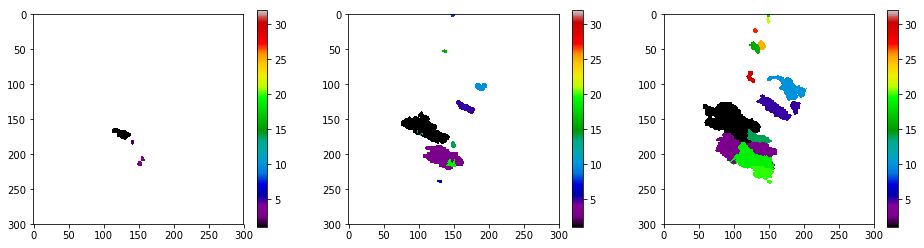

In [997]:
fig, ax = plt.subplots(1,3,figsize=(16,4))
m0=ax[0].imshow(ma.array(segment_features2[12], mask = segment_features2[12]<=0),cmap='nipy_spectral',vmin=1,vmax=segment_labels[12:37].max())
plt.colorbar(m0, ax=ax[0])
m1=ax[1].imshow(ma.array(segment_features2[24], mask = segment_features2[24]<=0),cmap='nipy_spectral',vmin=1,vmax=segment_labels[12:37].max())
plt.colorbar(m1, ax=ax[1])
m2=ax[2].imshow(ma.array(segment_features2[36], mask = segment_features2[36]<=0),cmap='nipy_spectral',vmin=1,vmax=segment_labels[12:37].max())
plt.colorbar(m2, ax=ax[2])

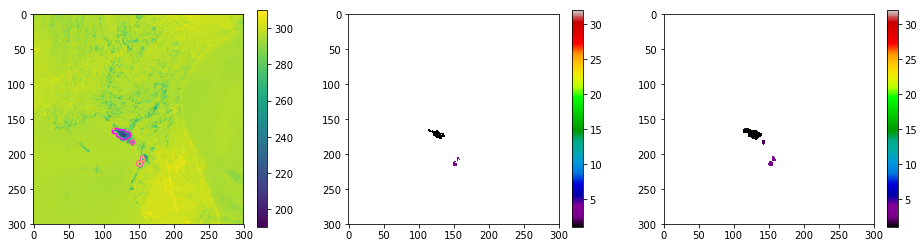

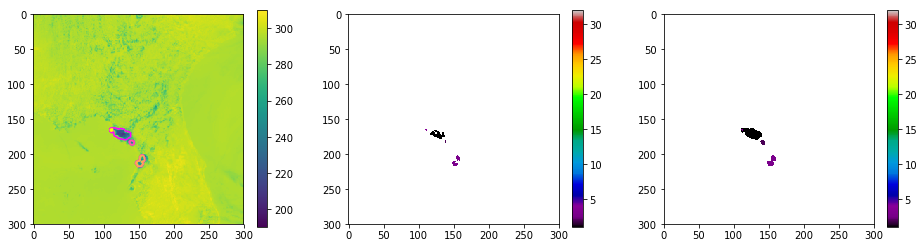

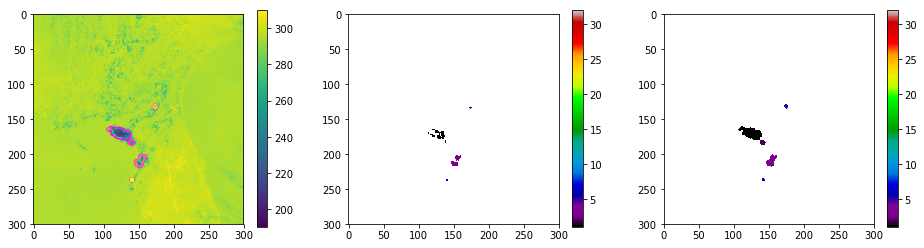

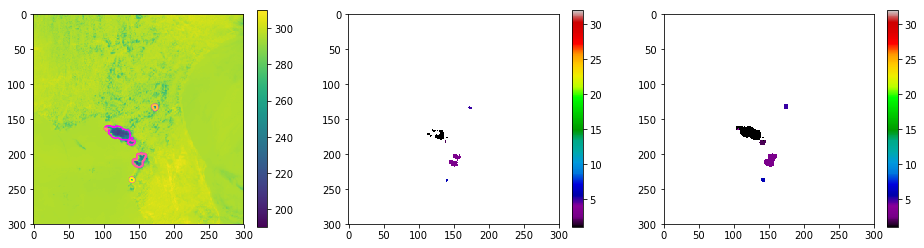

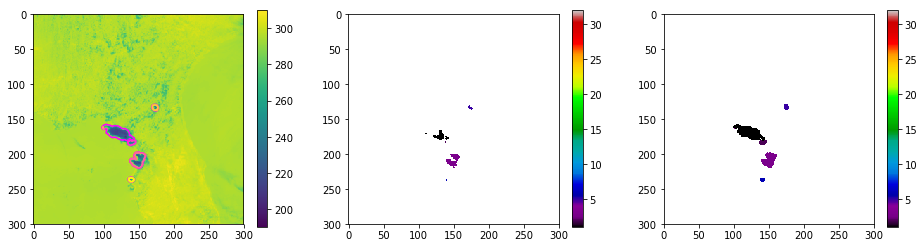

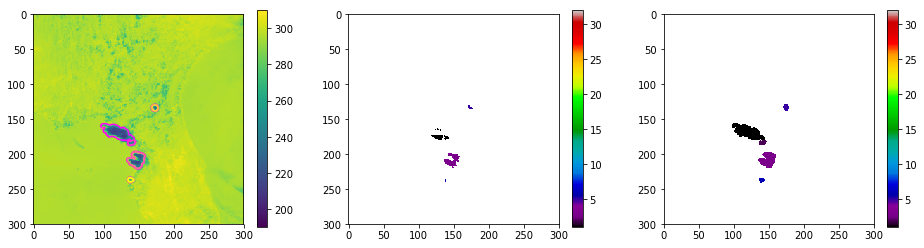

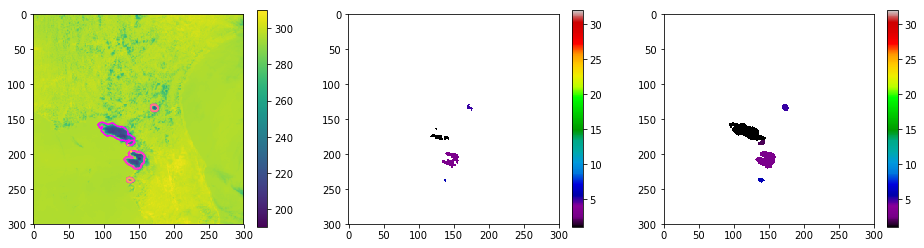

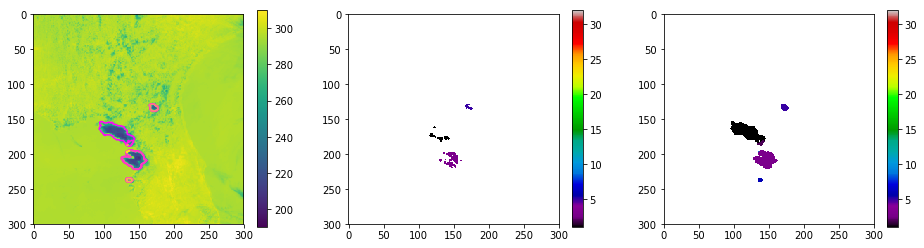

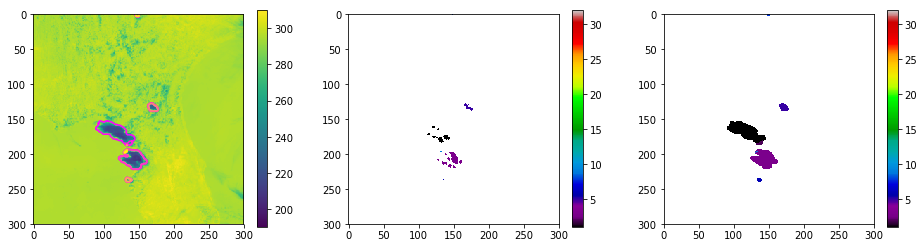

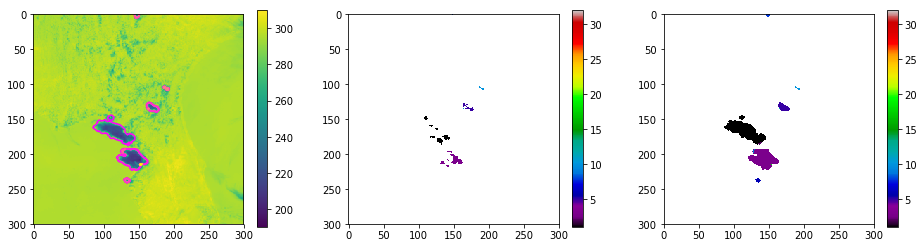

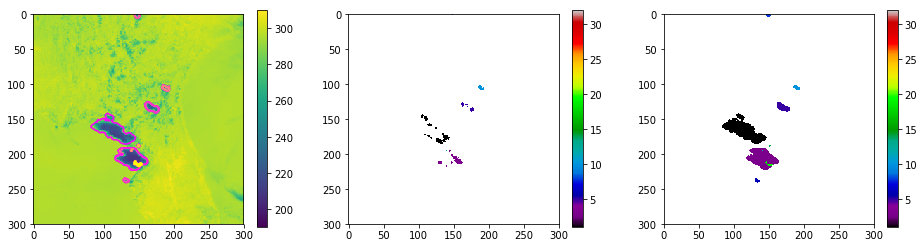

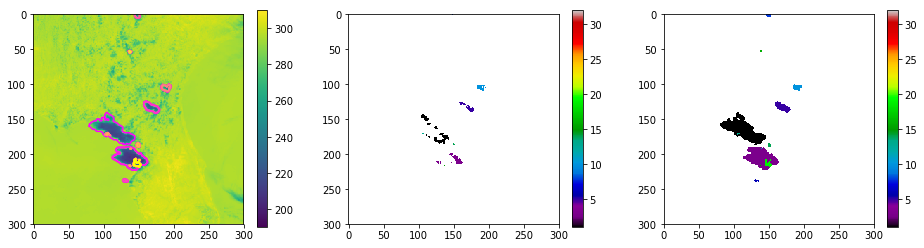

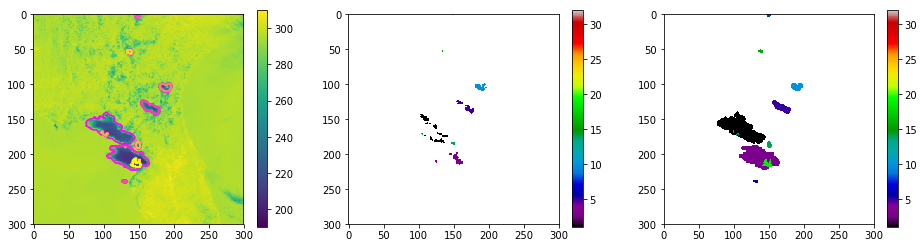

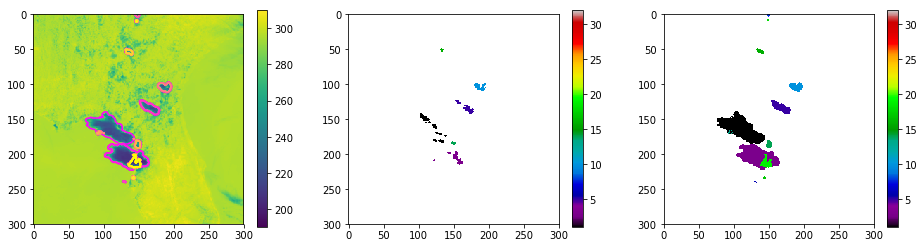

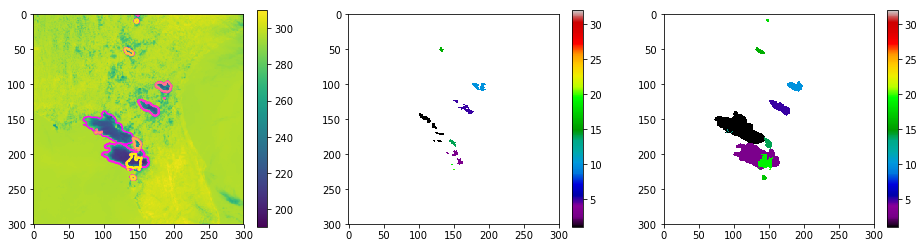

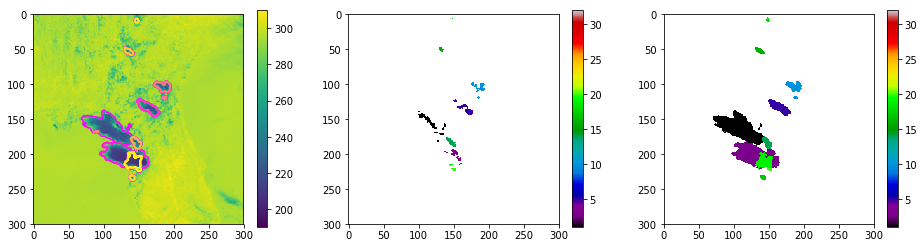

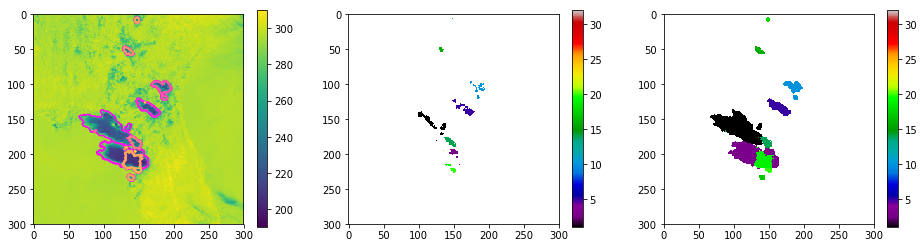

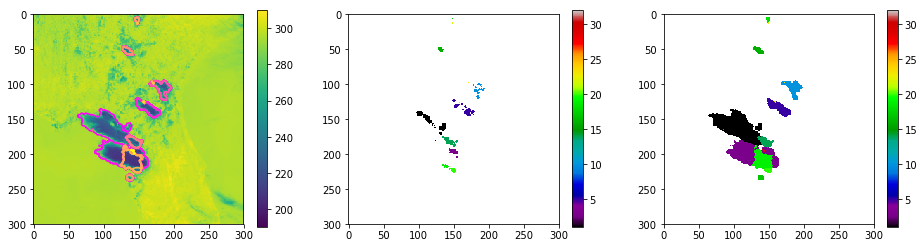

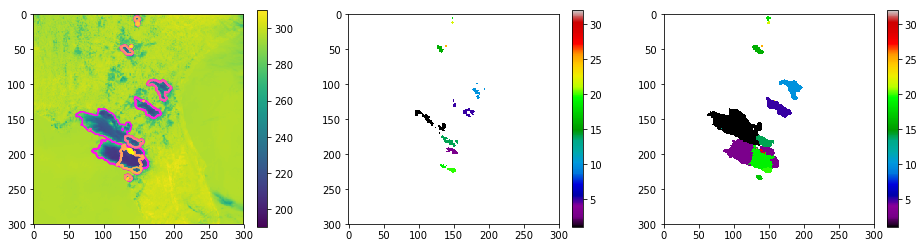

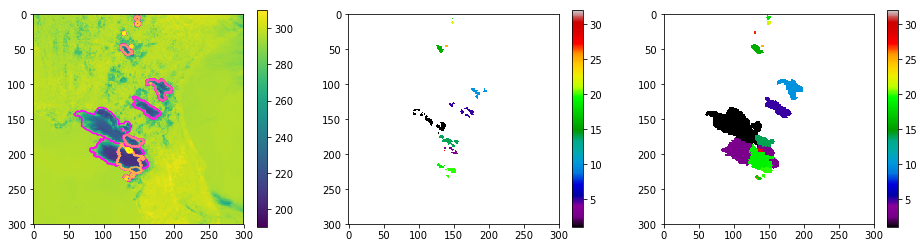

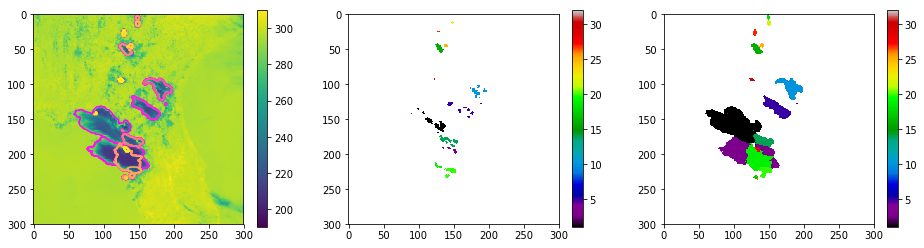

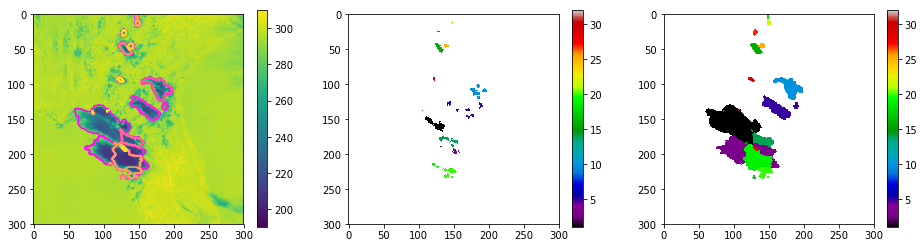

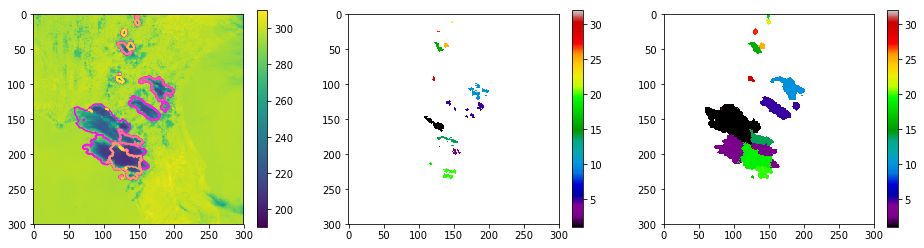

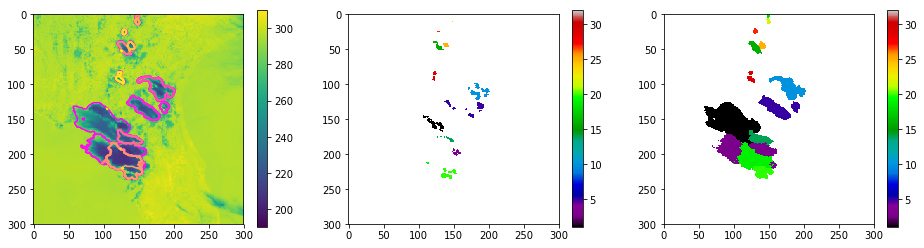

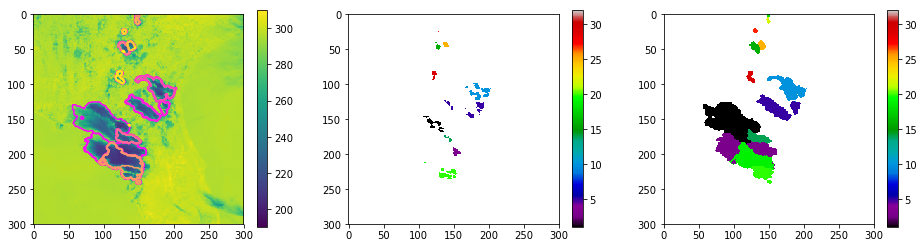

In [999]:
for i in range(12,37):
    fig, ax = plt.subplots(1,3, figsize=(16,4))
    m0 = ax[0].imshow(C13_data[i],vmin=190,vmax=310)
    plt.colorbar(m0, ax=ax[0])
    ax[0].contour(segment_features2[i],np.arange(segment_labels[12:37].max())+0.5,cmap='spring')
    m1=ax[1].imshow(ma.array(segment_labels[i], mask = segment_labels[i]<=0),cmap='nipy_spectral',vmin=1,vmax=segment_labels[12:37].max())
    plt.colorbar(m1, ax=ax[1])
    m2=ax[2].imshow(ma.array(segment_features2[i], mask = segment_features2[i]<=0),cmap='nipy_spectral',vmin=1,vmax=segment_labels[12:37].max())
    plt.colorbar(m2, ax=ax[2])
    

Picking out the mean brightness temperature of each region at each step and plotting one. Looks reasonable

In [725]:
inner_labels = ndi.label(features)[0]
bt_labels = [[np.nanmean(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

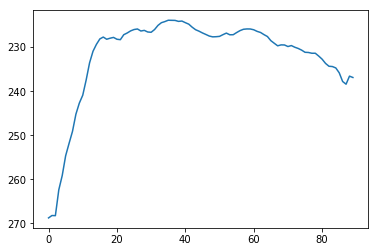

In [726]:
plt.plot(bt_labels[0])
plt.gca().invert_yaxis()

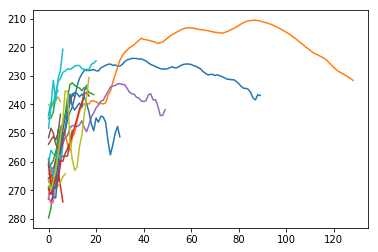

In [727]:
for i in range(len(bt_labels)):
    plt.plot(bt_labels[i])
plt.gca().invert_yaxis()

In [728]:
outer_labels = ndi.label(outer)[0]
bt_labels2 = [[np.nanmean(C13_data[j].data.ravel()[(outer_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(outer_labels[j]==i)] 
             for i in np.arange(1,outer_labels.max()+1)]

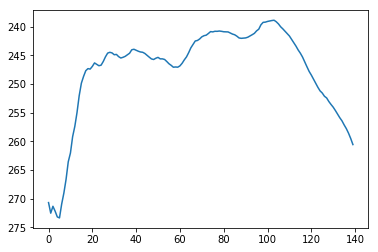

In [729]:
plt.plot(bt_labels2[1])
plt.gca().invert_yaxis()

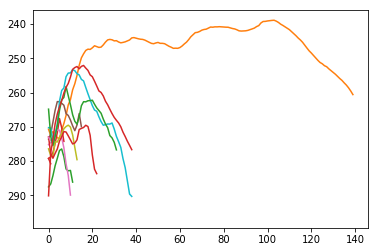

In [730]:
for i in range(len(bt_labels2)):
    plt.plot(bt_labels2[i])
plt.gca().invert_yaxis()

In [731]:
inner_labels = ndi.label(features)[0]
max_labels = [[np.nanmin(C13_data[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

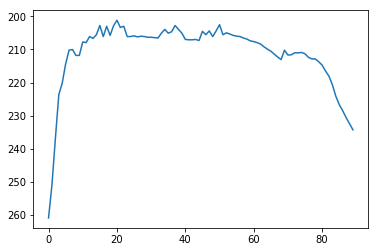

In [732]:
plt.plot(max_labels[0])
plt.gca().invert_yaxis()

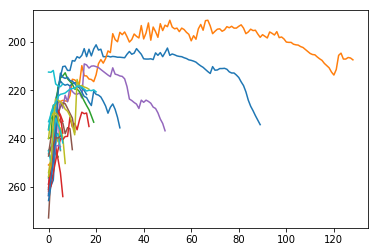

In [747]:
for i in range(len(max_labels)):
    plt.plot(max_labels[i])
plt.gca().invert_yaxis()

In [733]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmax(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

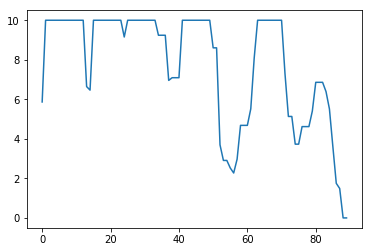

In [734]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

In [735]:
inner_labels = ndi.label(features)[0]
growth_labels = [[np.nanmean(bt_growth[j].data.ravel()[(inner_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(inner_labels[j]==i)] 
             for i in np.arange(1,inner_labels.max()+1)]

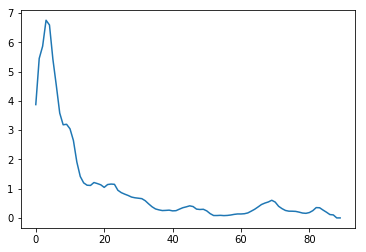

In [736]:
plt.plot(growth_labels[0])
# plt.gca().invert_yaxis()

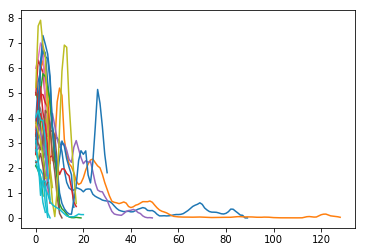

In [801]:
for i in range(len(growth_labels)):
    plt.plot(growth_labels[i])

Now for segments

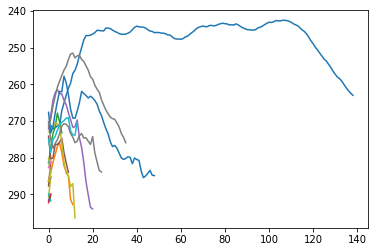

In [918]:
segment_labels = ndi.label(segment_features2)[0]
bt_labels = [[np.nanmean(C13_data[j].data.ravel()[(segment_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(segment_labels[j]==i)] 
             for i in np.arange(1,segment_labels.max()+1)]

for i in range(len(bt_labels)):
    plt.plot(bt_labels[i])
plt.gca().invert_yaxis()

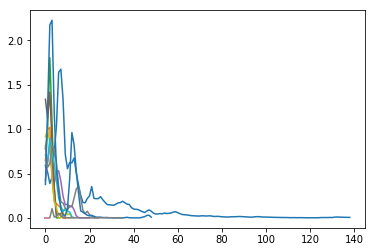

In [920]:
growth_labels = [[np.nanmean(bt_growth[j].ravel()[(segment_labels[j]==i).ravel()]) 
              for j in range(C13_data.shape[0]) if np.any(segment_labels[j]==i)] 
             for i in np.arange(1,segment_labels.max()+1)]
for i in range(len(growth_labels)):
    plt.plot(growth_labels[i])

Comparison with GLM data

In [737]:
glm_path = '/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/17[01]/*'
glm_files = glob(glm_path+'/OR_GLM-L2-LCFA_*.nc')
glm_files.sort()
glm_dates = [abi_tools.get_abi_date_from_filename(f) for f in glm_files]
glm_dates_array = np.array(glm_dates)

In [738]:
glm_files[0]

'/gws/nopw/j04/eo_shared_data_vol2/scratch/satellite/GOES16/GLM/2018/170/00/OR_GLM-L2-LCFA_G16_s20181700000000_e20181700000200_c20181700000226.nc'

In [739]:
p = abi_tools.get_abi_proj(C13_data[0])
height=C13_data[0].goes_imager_projection.perspective_point_height

In [740]:
# Get lightning event and flash locations
event_x = []
event_y = []
flash_x = []
flash_y = []
for abi_file in goes_files:
#     abi_file = goes_files[f_ind]
    wh_dates = np.all([glm_dates_array>=abi_file[0], glm_dates_array<(abi_file[0]+timedelta(minutes=5))], axis=0)
    matched_glm_files = np.array(glm_files)[wh_dates]
    t_event_x = []
    t_event_y = []
    t_flash_x = []
    t_flash_y = []
    for glm_file in matched_glm_files:
        with xr.open_dataset(glm_file) as glm_ds:
            temp_x, temp_y = (output/height for output in p(glm_ds.event_lon.data, glm_ds.event_lat.data))
            t_event_x.append(temp_x)
            t_event_y.append(temp_y)
            temp_x, temp_y = (output/height for output in p(glm_ds.flash_lon.data, glm_ds.flash_lat.data))
            t_flash_x.append(temp_x)
            t_flash_y.append(temp_y)

    event_x.append(np.concatenate(t_event_x))
    event_y.append(np.concatenate(t_event_y))
    flash_x.append(np.concatenate(t_flash_x))
    flash_y.append(np.concatenate(t_flash_y))

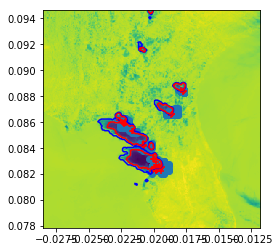

In [741]:
plt.imshow(C13_data[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
plt.contour(C13_data[0].x, C13_data[0].y, outer[f_ind],[0.5],colors=['blue'])
plt.contour(C13_data[0].x, C13_data[0].y, features[f_ind],[0.5],colors=['red'])

wh = np.all([event_x[f_ind]>=C13_data[0].x[0].item(),
             event_x[f_ind]<=C13_data[0].x[-1].item(),
             event_y[f_ind]>=C13_data[0].y[-1].item(),
             event_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(event_x[f_ind][wh], event_y[f_ind][wh])
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [742]:
outer_dist = ndi.distance_transform_edt(np.logical_not(outer))

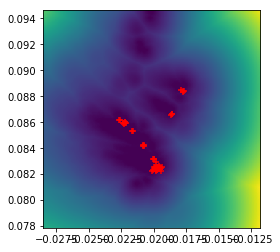

In [743]:
plt.imshow(outer_dist[f_ind], extent=(C13_data[0].x[0].item(),
                                C13_data[0].x[-1].item(),
                                C13_data[0].y[-1].item(),
                                C13_data[0].y[0].item()))
# plt.colorbar()
wh = np.all([flash_x[f_ind]>=C13_data[0].x[0].item(),
             flash_x[f_ind]<=C13_data[0].x[-1].item(),
             flash_y[f_ind]>=C13_data[0].y[-1].item(),
             flash_y[f_ind]<=C13_data[0].y[0].item()],
            axis=0)
plt.scatter(flash_x[f_ind][wh], flash_y[f_ind][wh], c='r', marker='+')


In [744]:
dist_test = interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[f_ind][::-1],
                                np.stack([flash_y[f_ind], flash_x[f_ind]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan)

In [745]:
outer_dists = []
for i in range(outer_dist.shape[0]):
    outer_dists.append(interpolate.interpn((C13_data[0].y[::-1], C13_data[0].x),
                                outer_dist[i][::-1],
                                np.stack([flash_y[i], flash_x[i]], axis=-1),
                                method='linear',
                                bounds_error=False,
                                fill_value=np.nan))
outer_dists = np.concatenate(outer_dists)
outer_dists = ma.array(outer_dists, mask=np.isnan(outer_dists))

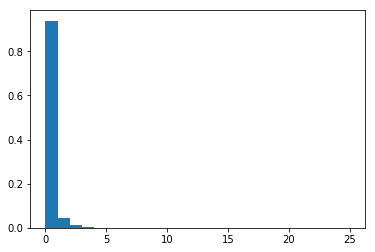

In [746]:
h = plt.hist(outer_dists, bins=np.arange(0,26), density=True,stacked=True)

In [1001]:
C13_data.coords

Coordinates:
    y_image  float32 0.08624
    x_image  float32 -0.03136
  * t        (t) datetime64[ns] 2018-06-19T16:03:43.802067072 ... 2018-06-20T03:58:44.157608064
  * y        (y) float32 0.094612 0.094556004 ... 0.077924006 0.077868
  * x        (x) float32 -0.028531998 -0.028476 ... -0.011844002 -0.011788003

In [ ]:
C13_data.